# Juliaではじめる会計でーたさいえんす　第3回

PythonやRと比べるとJuliaはまだまだ開発途上なところがあり、時にはJuliaに適切なパッケージ(ライブラリ)がない場合があります。比較的簡単なプログラムの場合は練習のため自作してみるのもよいかもしれませんが、Juliaでは他のプログラミング言語の部分的活用が比較的スムーズにできます。今回は、最後のSARIMAモデルのところ以外はJuliaで頑張りましたが、途中何箇所かはRを呼び出す方法でも対応できます。

本稿は、新井康平先生のRのコード( https://twitter.com/araikohei_osaka/status/1279736630337695745?s=20 )を元に書かれたものです。元の『企業会計』8月号の「Pythonではじめる会計データサイエンス」(第3回)については、私が海外にいるため、参照できておりません。

<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#データセットの読込と加工" data-toc-modified-id="データセットの読込と加工-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>データセットの読込と加工</a></span><ul class="toc-item"><li><span><a href="#点過程データの読込とグラフ化" data-toc-modified-id="点過程データの読込とグラフ化-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>点過程データの読込とグラフ化</a></span></li><li><span><a href="#時系列データの読込と加工" data-toc-modified-id="時系列データの読込と加工-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>時系列データの読込と加工</a></span></li><li><span><a href="#移動平均の作成とグラフ化" data-toc-modified-id="移動平均の作成とグラフ化-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>移動平均の作成とグラフ化</a></span></li><li><span><a href="#季節指数の作成とグラフ化" data-toc-modified-id="季節指数の作成とグラフ化-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>季節指数の作成とグラフ化</a></span></li></ul></li><li><span><a href="#SARIMAモデルによる時系列分析と予測" data-toc-modified-id="SARIMAモデルによる時系列分析と予測-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>SARIMAモデルによる時系列分析と予測</a></span><ul class="toc-item"><li><span><a href="#第一法" data-toc-modified-id="第一法-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>第一法</a></span></li><li><span><a href="#第二法" data-toc-modified-id="第二法-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>第二法</a></span></li><li><span><a href="#詳細の確認" data-toc-modified-id="詳細の確認-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>詳細の確認</a></span></li><li><span><a href="#予測結果の格納とグラフ化" data-toc-modified-id="予測結果の格納とグラフ化-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>予測結果の格納とグラフ化</a></span></li></ul></li></ul></div>

## データセットの読込と加工

In [1]:
using CSV, DataFrames, StatsPlots

### 点過程データの読込とグラフ化

In [2]:
tenkatei = CSV.read(download("http://www.chuokeizai.co.jp/acc/202008/tenkatei.csv"))
first(tenkatei, 6)

,time,count
,Int64,Int64
1,1,0
2,2,0
3,3,7
4,4,0
5,5,0
6,6,2


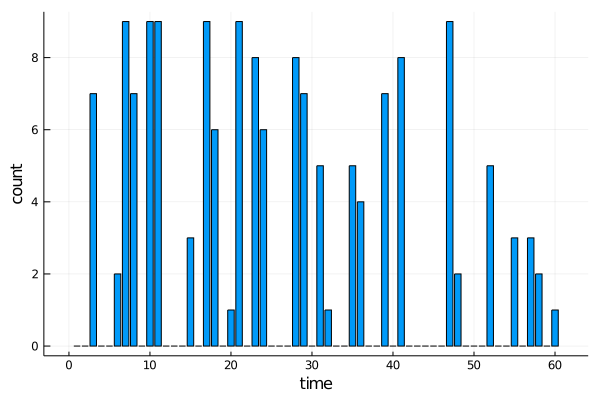

In [3]:
@df tenkatei bar(:time, :count, xlabel = "time", ylabel = "count", label = false)

### 時系列データの読込と加工

In [4]:
df = CSV.read(download("http://www.chuokeizai.co.jp/acc/202008/demodata2.csv"))
first(df, 6)

,time,amount
,String,Int64
1,2015/4/1,8902824
2,2015/5/1,7640687
3,2015/6/1,8068106
4,2015/7/1,7203392
5,2015/8/1,7105682
6,2015/9/1,6205215


In [5]:
using Dates
df.time = Date.(df.time, "yyyy/mm/dd")

60-element Array{Date,1}:
 2015-04-01
 2015-05-01
 2015-06-01
 2015-07-01
 2015-08-01
 2015-09-01
 2015-10-01
 2015-11-01
 ⋮
 2019-09-01
 2019-10-01
 2019-11-01
 2019-12-01
 2020-01-01
 2020-02-01
 2020-03-01

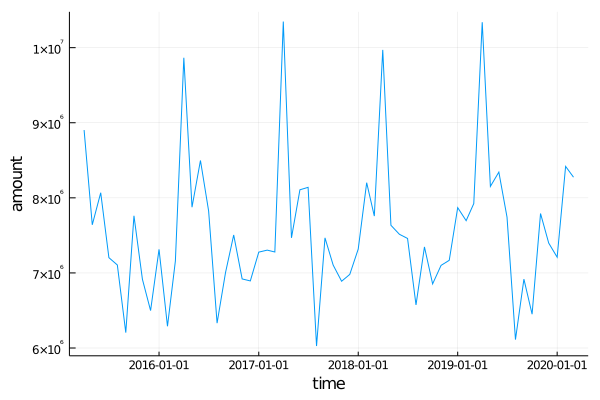

In [6]:
@df df plot(:time, :amount,  xlabel = "time", ylabel = "amount", label = false)

### 移動平均の作成とグラフ化
残念ながら、Juliaにはまだ適切なパッケージがない部分です。ただ過去〜ヶ月分の平均を出すだけの通常の移動平均であれば、TimeSeriesパッケージで対応可能ですが、この移動平均の場合は、RをJuliaから呼び出すか、自作する必要があります。これはそれほど複雑ではないので、自作してみました。

In [7]:
ma_trend = []
for i = 1:size(df)[1]
    try
        temp = ((df[i-6:i+6, :amount])' * vcat(0.5, ones(11), 0.5))/12
        ma_trend = vcat(ma_trend, temp)
    catch
        ma_trend = vcat(ma_trend, missing)
    end
end
df.amount_ma = ma_trend
first(df, 10)

,time,amount,amount_ma
,Date,Int64,Any
1,2015-04-01,8902824,missing
2,2015-05-01,7640687,missing
3,2015-06-01,8068106,missing
4,2015-07-01,7203392,missing
5,2015-08-01,7105682,missing
6,2015-09-01,6205215,missing
7,2015-10-01,7760793,7.29538e6
8,2015-11-01,6915666,7.34526e6
9,2015-12-01,6498458,7.37294e6


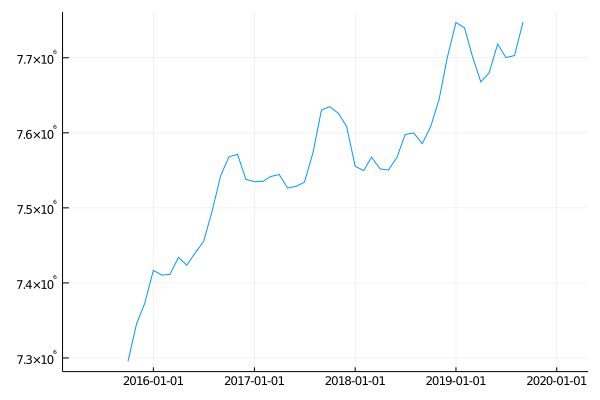

In [8]:
@df df plot(:time, :amount_ma, label = false)

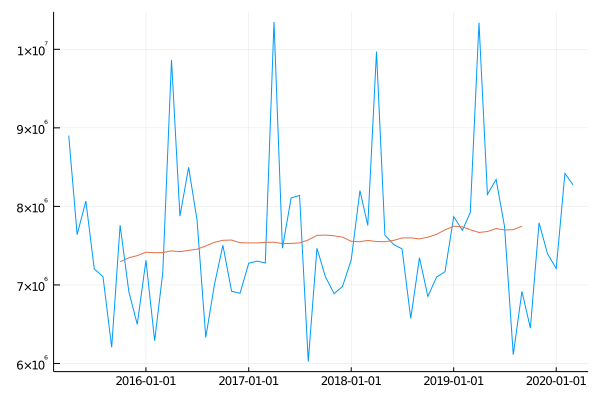

In [9]:
@df df plot(:time, [:amount, :amount_ma], label = false)

### 季節指数の作成とグラフ化
これも自作です。あと、Statisticsパッケージは平均値を計算するmean関数のためだけにインポートしています…

In [10]:
using Statistics
df.month = month.(df.time)
df.temp = df.amount .- df.amount_ma
df_seasonarity = combine(groupby(dropmissing(df), :month), :temp => mean => :seasonal)
df_seasonarity.seasonal = df_seasonarity.seasonal .- mean(df_seasonarity.seasonal)
df = leftjoin(df, df_seasonarity, on = :month)
select!(df, Not([:temp, :month]))

,time,amount,amount_ma,seasonal
,Date,Int64,Any,Float64?
1,2015-04-01,8902824,missing,2.58088e6
2,2015-05-01,7640687,missing,236893.0
3,2015-06-01,8068106,missing,551888.0
4,2015-07-01,7203392,missing,219560.0
5,2015-08-01,7105682,missing,-1.33248e6
6,2015-09-01,6205215,missing,-443134.0
7,2015-10-01,7760793,7.29538e6,-220681.0
8,2015-11-01,6915666,7.34526e6,-590741.0
9,2015-12-01,6498458,7.37294e6,-670059.0


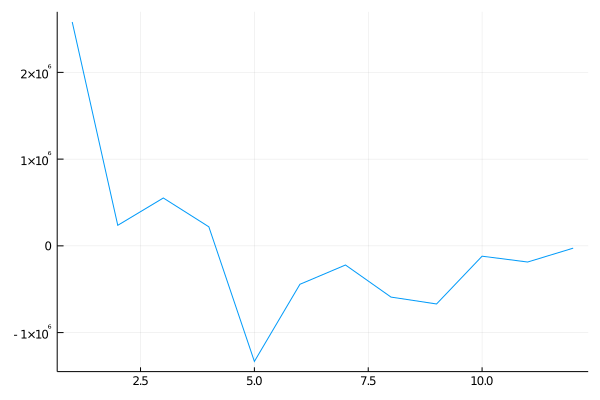

In [11]:
plot(1:12, df[1:12, :seasonal], label = false)

## SARIMAモデルによる時系列分析と予測
残念ながら、データから最適なSARIMAモデルを選んでくれるパッケージは、私の確認した限り、まだJuliaには存在しません。また、これは最適化問題(i.e. AICの最小化)が絡むなど、気軽に自作できるようなものでもありません。このような場合、Juliaから適切な他のプログラミング言語を呼び出すことが有効です(Juliaはスムーズに他言語と連携できる言語です)。今回は、私がRのコードしか確認できていないため、RCallを使ってRを呼び出しますが、当然、Pythonを呼び出すこともできます。RCallのインストール方法や使い方の詳細は、公式マニュアル http://juliainterop.github.io/RCall.jl/stable/installation/ をご覧下さい。使用例としては、黒木先生のノート https://nbviewer.jupyter.org/gist/genkuroki/c72aa29f24156e46c7564852e4f36c9a が有用です。

### 第一法
JuliaからRを呼ぶ方法は色々ありますが、まずは、部分的に特定のライブラリや関数のみ活用する方法を記載します。ただ、この方法だと、コードは見やすいですが、JuliaとRの間で何度もデータのやり取りが行われるため、あまり効率的ではなく、大量のデータを処理する際は避けた方がよい、とされています。

In [12]:
using RCall
@rimport forecast as rfc
df_r_train = R"ts($df$amount[1:48], start = c(2015, 4), frequency = 12)"  # Juliaの変数をRに渡す場合は、$を前につけて下さい。
modelSARIMA = rfc.auto_arima(df_r_train, ic = "aic", stepwise = false, seasonal = true)
df_fc = rfc.forecast(modelSARIMA, h = 24)

┌ Warning: RCall.jl: Registered S3 method overwritten by 'quantmod':
│   method            from
│   as.zoo.data.frame zoo 
└ @ RCall /Users/kohki/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{VecSxp}
         Point Forecast   Lo 80    Hi 80   Lo 95    Hi 95
Apr 2019        9840394 9338606 10342182 9072976 10607813
May 2019        7552237 7050794  8053679 6785346  8319127
Jun 2019        7634162 7133027  8135297 6867742  8400582
Jul 2019        6842409 6313473  7371344 6033472  7651345
Aug 2019        6950386 6402197  7498576 6112002  7788771
Sep 2019        7269100 6707586  7830614 6410338  8127862
Oct 2019        6709836 6146182  7273490 5847802  7571870
Nov 2019        7332200 6768760  7895640 6470493  8193907
Dec 2019        7225969 6661113  7790824 6362096  8089841
Jan 2020        8211824 7644602  8779047 7344332  9079316
Feb 2020        7238853 6669768  7807937 6368513  8109192
Mar 2020        7862934 7293246  8432621 6991672  8734196
Apr 2020        9941205 8956671 10925739 8435490 11446920
May 2020        7316660 6332359  8300961 5811302  8822018
Jun 2020        7818424 6834052  8802796 6312957  9323891
Jul 2020        6715862 5690699  7741025 5148010  828371

### 第二法
こちらは、Rのコードをそのまま実行する方法です。JuliaからRにデータセットを送り、Rが最終的な実行結果をJulia側に引き渡すという一往復のみで済むので効率的です。

In [13]:
df_fc = R"""
library(forecast)
df_r_train = ts($df$amount[1:48], start = c(2015, 4), frequency = 12)  # Juliaの変数をRに渡す場合は、$を前につけて下さい。
modelSARIMA = auto.arima(df_r_train, ic = "aic", stepwise = F, seasonal = T)
forecast(modelSARIMA, h = 24)
"""

RObject{VecSxp}
         Point Forecast   Lo 80    Hi 80   Lo 95    Hi 95
Apr 2019        9840394 9338606 10342182 9072976 10607813
May 2019        7552237 7050794  8053679 6785346  8319127
Jun 2019        7634162 7133027  8135297 6867742  8400582
Jul 2019        6842409 6313473  7371344 6033472  7651345
Aug 2019        6950386 6402197  7498576 6112002  7788771
Sep 2019        7269100 6707586  7830614 6410338  8127862
Oct 2019        6709836 6146182  7273490 5847802  7571870
Nov 2019        7332200 6768760  7895640 6470493  8193907
Dec 2019        7225969 6661113  7790824 6362096  8089841
Jan 2020        8211824 7644602  8779047 7344332  9079316
Feb 2020        7238853 6669768  7807937 6368513  8109192
Mar 2020        7862934 7293246  8432621 6991672  8734196
Apr 2020        9941205 8956671 10925739 8435490 11446920
May 2020        7316660 6332359  8300961 5811302  8822018
Jun 2020        7818424 6834052  8802796 6312957  9323891
Jul 2020        6715862 5690699  7741025 5148010  828371

### 詳細の確認

In [14]:
df_fc[:mean]

RObject{RealSxp}
         Jan     Feb     Mar     Apr     May     Jun     Jul     Aug     Sep
2019                         9840394 7552237 7634162 6842409 6950386 7269100
2020 8211824 7238853 7862934 9941205 7316660 7818424 6715862 6983268 7300589
2021 8232985 7243260 7842807                                                
         Oct     Nov     Dec
2019 6709836 7332200 7225969
2020 6641456 7402042 7175799
2021                        


どういうモデルをRが選んだのかの確認もできます。

In [15]:
df_fc[:model]

RObject{VecSxp}
Series: df_r_train 
ARIMA(3,0,1)(0,1,1)[12] 

Coefficients:
          ar1      ar2     ar3     ma1    sma1
      -0.8658  -0.0011  0.3247  0.8821  0.6007
s.e.   0.1755   0.2455  0.1901  0.0934  0.4015

sigma^2 estimated as 1.51e+11:  log likelihood=-514.88
AIC=1041.77   AICc=1044.66   BIC=1051.27


### 予測結果の格納とグラフ化

In [16]:
df_result = DataFrame(time = 1:72,
                      actual = vcat(df.amount, missings(12)),
                      forecast = vcat(missings(48), rcopy(df_fc[:mean])))

,time,actual,forecast
,Int64,Int64?,Float64?
1,1,8902824,missing
2,2,7640687,missing
3,3,8068106,missing
4,4,7203392,missing
5,5,7105682,missing
6,6,6205215,missing
7,7,7760793,missing
8,8,6915666,missing
9,9,6498458,missing


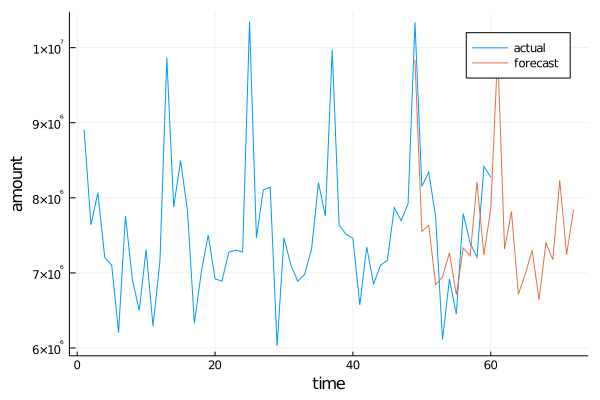

In [17]:
@df df_result plot(:time, [:actual :forecast], 
                    label = ["actual" "forecast"], 
                    xlabel = "time", 
                    ylabel = "amount")